In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import tables
import pandas as pd
import matplotlib
from scipy.optimize import curve_fit    
pd.set_option('display.max_columns', None)

# Display settings for Jupyter Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Importing custom utility functions
sys.path.insert(0, os.getcwd() + "/../scripts/")
import auxiliar as aux
import lstpipeline

In [2]:
def quadratic_func(x, a, b, c):
    return c * x**2 + b * x + a

p0a, p0b, p0c = -0.44751321, 3.62502037, -1.43611437
p1a, p1b, p1c = -2.89253919, 0.99443581, -0.34013068

### Paths to data and results

In [3]:
# Root path of this script
root = os.getcwd() + "/"
# Objects directory
root_objects = root + "objects/"

# Directory of all the night-wise datachecks
root_dchecks = "/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_"

# Some filenames -------------------
# Filename of the datacheck dictionary
fname_datacheck_dict = root_objects + "tmp_datacheck_dict.pkl"

# Flags for computing or not different parts
# Compute the datacheck dictionary
compute_datacheck_dict = False

# Create needed folders
for dir in [root_objects]:
    if not os.path.exists(dir):
        os.makedirs(dir)

### Extracting dates and parameters of all runs/subruns

In [4]:
%%time
if compute_datacheck_dict:

    run_number   = [] # Run numbers
    srun_number  = [] # Subrun numbers
    timestamps   = [] # Timestamps of each subrun
    time_elapsed = [] # Elapsed time of each subrun
    mean_azimuth = [] # Mean azimuth of each run
    mean_zenith_distance = [] # Mean zenith of each run
    zd_corrected_intensity_at_half_peak_rate = [] # ZD corrected intensity at half peak rate
    intensity_at_half_peak_rate = [] # intensity at half peak rate
    cosmics_peak_rate = []
    zd_corrected_cosmics_rate_at_422_pe = [] # ZD corrected cosmics rate at 422 pe
    zd_corrected_delta_cosmics_rate_at_422_pe = [] # ZD corrected delta cosmics rate at 422 pe
    cosmics_rate_at_422_pe = [] # ZD corrected cosmics rate at 422 pe
    delta_cosmics_rate_at_422_pe = [] # ZD corrected delta cosmics rate at 422 pe
    zd_corrected_cosmics_spectral_index = [] # ZD corrected cosmics spectral index
    cosmics_spectral_index = [] # ZD corrected cosmics spectral index
    zd_corrected_delta_cosmics_spectral_index = [] # ZD corrected delta cosmics spectral index
    light_yield = [] # Light yield
    intensity_spectrum_fit_p_value = []
    diffuse_nsb_std = []
    charge_mean = []
    ra = []
    dec = []

    # All the datachecks for all the nights
    dchecks = np.sort(glob.glob(root_dchecks + "*.h5"))

    # We iterate over all the datachecks
    for i, dcheck in enumerate(dchecks[:]):

        print(f"Analysing... {i:3}/{len(dchecks)}") if i % 30 == 0 else None

        # The datacheck file of the run summary (runwise)
        ds = pd.read_hdf(dcheck, key="runsummary")
        # The datacheck file of the intensity spectrums (subrunwise)
        di = pd.read_hdf(dcheck, key="cosmics_intensity_spectrum")
        # 
        # dp = pd.read_hdf(dcheck, key="pedestals")
        try:
            dp = pd.read_hdf(dcheck, key="pedestals")
            dp_flag = True
        except:
            dp_flag = False
            
        # Iterating over all the entries of each night, the subruns
        for j in range(len(ds)):

            # Reference run number
            runref = ds["runnumber"].iloc[j]
            runra, rundec = ds["mean_ra"].iloc[j], ds["mean_dec"].iloc[j]
            
            # Intensity datacheck for only the subruns of the reference run
            di_run = di.query(f"runnumber == {runref}")
            if dp_flag != False:
                dp_run = dp.query(f"runnumber == {runref}")
            
            # Subrun iteration and storing all the data we are interested in
            for k in range(len(di_run)):

                run_number.append(runref)
                ra.append(runra)
                dec.append(rundec)
                srun_number.append(di_run["subrun"].iloc[k])
                timestamps.append(datetime.fromtimestamp(di_run["time"].iloc[k]))
                time_elapsed.append(di_run["corrected_elapsed_time"].iloc[k])
                mean_azimuth.append(ds["mean_azimuth"].iloc[j])
                mean_zenith_distance.append(np.arccos(di_run["cos_zenith"].iloc[k]))
                zd_corrected_intensity_at_half_peak_rate.append(di_run["ZD_corrected_intensity_at_half_peak_rate"].iloc[k])
                intensity_at_half_peak_rate.append(di_run["intensity_at_half_peak_rate"].iloc[k])
                cosmics_peak_rate.append(di_run["cosmics_peak_rate"].iloc[k])
                zd_corrected_cosmics_rate_at_422_pe.append(di_run["ZD_corrected_cosmics_rate_at_422_pe"].iloc[k])
                zd_corrected_delta_cosmics_rate_at_422_pe.append(di_run["ZD_corrected_delta_cosmics_rate_at_422_pe"].iloc[k])
                cosmics_rate_at_422_pe.append(di_run["cosmics_rate_at_422_pe"].iloc[k])
                delta_cosmics_rate_at_422_pe.append(di_run["delta_cosmics_rate_at_422_pe"].iloc[k])
                zd_corrected_cosmics_spectral_index.append(di_run["ZD_corrected_cosmics_spectral_index"].iloc[k])
                cosmics_spectral_index.append(di_run["cosmics_spectral_index"].iloc[k])
                zd_corrected_delta_cosmics_spectral_index.append(di_run["delta_cosmics_spectral_index"].iloc[k])
                light_yield.append(di_run["light_yield"].iloc[k])
                intensity_spectrum_fit_p_value.append(di_run["intensity_spectrum_fit_p_value"].iloc[k])
                diffuse_nsb_std.append(di_run["diffuse_nsb_std"].iloc[k])

                if dp_flag != False:
                    try:
                        charge_mean.append(dp_run["charge_mean"].iloc[k])
                    except:
                        charge_mean.append(np.nan)
                else:
                    charge_mean.append(np.nan)

    print(f"Analysing... {len(dchecks):3}/{len(dchecks)}\n")

    # Now we are going to sort looking to the timestamps
    _, run_number = aux.sort_based(run_number, timestamps)
    _, ra = aux.sort_based(ra, timestamps)
    _, dec = aux.sort_based(dec, timestamps)
    _, srun_number = aux.sort_based(srun_number, timestamps)
    _, time_elapsed = aux.sort_based(time_elapsed, timestamps)
    _, mean_azimuth = aux.sort_based(mean_azimuth, timestamps)
    _, mean_zenith_distance = aux.sort_based(mean_zenith_distance, timestamps)
    _, zd_corrected_intensity_at_half_peak_rate = aux.sort_based(zd_corrected_intensity_at_half_peak_rate, timestamps)
    _, intensity_at_half_peak_rate = aux.sort_based(intensity_at_half_peak_rate, timestamps)
    _, cosmics_peak_rate = aux.sort_based(cosmics_peak_rate, timestamps)
    _, zd_corrected_cosmics_rate_at_422_pe = aux.sort_based(zd_corrected_cosmics_rate_at_422_pe, timestamps)
    _, zd_corrected_delta_cosmics_rate_at_422_pe = aux.sort_based(zd_corrected_delta_cosmics_rate_at_422_pe, timestamps)
    _, cosmics_rate_at_422_pe = aux.sort_based(cosmics_rate_at_422_pe, timestamps)
    _, delta_cosmics_rate_at_422_pe = aux.sort_based(delta_cosmics_rate_at_422_pe, timestamps)
    _, zd_corrected_cosmics_spectral_index = aux.sort_based(zd_corrected_cosmics_spectral_index, timestamps)
    _, cosmics_spectral_index = aux.sort_based(cosmics_spectral_index, timestamps)
    _, zd_corrected_delta_cosmics_spectral_index = aux.sort_based(zd_corrected_delta_cosmics_spectral_index, timestamps)
    _, intensity_spectrum_fit_p_value = aux.sort_based(intensity_spectrum_fit_p_value, timestamps)
    _, diffuse_nsb_std = aux.sort_based(diffuse_nsb_std, timestamps)
    _, charge_mean = aux.sort_based(charge_mean, timestamps)
    timestamps, light_yield = aux.sort_based(light_yield, timestamps)

    # Creating the data dictionary
    dict_dcheck = {
        "run" : np.array(run_number),
        "ra" : np.array(ra),
        "dec" : np.array(dec),        
        "srun" : np.array(srun_number),
        "time" : np.array(timestamps),
        "telapsed" : np.array(time_elapsed),
        "az" : np.rad2deg(mean_azimuth),
        "zd" : np.rad2deg(mean_zenith_distance),
        "ZD_corrected_intensity_at_half_peak_rate" : np.array(zd_corrected_intensity_at_half_peak_rate),
        "intensity_at_half_peak_rate" : np.array(intensity_at_half_peak_rate),
        "cosmics_peak_rate" : np.array(cosmics_peak_rate),
        "ZD_corrected_cosmics_rate_at_422_pe" : np.array(zd_corrected_cosmics_rate_at_422_pe),
        "ZD_corrected_delta_cosmics_rate_at_422_pe" : np.array(zd_corrected_delta_cosmics_rate_at_422_pe),
        "cosmics_rate_at_422_pe" : np.array(cosmics_rate_at_422_pe),
        "delta_cosmics_rate_at_422_pe" : np.array(delta_cosmics_rate_at_422_pe),
        "ZD_corrected_cosmics_spectral_index" : np.array(zd_corrected_cosmics_spectral_index),
        "cosmics_spectral_index" : np.array(cosmics_spectral_index),
        "delta_cosmics_spectral_index" : np.array(zd_corrected_delta_cosmics_spectral_index),
        "intensity_spectrum_fit_p_value" : np.array(intensity_spectrum_fit_p_value),
        "diffuse_nsb_std" : np.array(diffuse_nsb_std),
        "light_yield" : np.array(light_yield),
        "charge_mean" : np.array(charge_mean),
    }        

    # Saving the objects in the objects directory
    with open(fname_datacheck_dict, 'wb') as f:
        pickle.dump(dict_dcheck, f, pickle.HIGHEST_PROTOCOL)  
else:
    # To read the file:
    with open(fname_datacheck_dict, 'rb') as f:
            dict_dcheck = pickle.load(f)    

CPU times: user 216 ms, sys: 321 ms, total: 537 ms
Wall time: 1.42 s


### Creating the total dictionary run-subrun-wise

In [5]:
%%time
total_dict = {}

# We create an entry per run
for run in np.unique(dict_dcheck["run"]):
    total_dict[run] = {}

# Converting dcheck dictionary to total dictionary
for i in range(len(dict_dcheck["run"])):

    total_dict[dict_dcheck["run"][i]][dict_dcheck["srun"][i]] = {
        "ra" : dict_dcheck["ra"][i],
        "dec" : dict_dcheck["dec"][i],
        "time" : dict_dcheck["time"][i],
        "telapsed" : dict_dcheck["telapsed"][i],
        "az" : dict_dcheck["az"][i],
        "zd" : dict_dcheck["zd"][i],
        "ZD_corrected_intensity_at_half_peak_rate" : dict_dcheck["ZD_corrected_intensity_at_half_peak_rate"][i],
        "intensity_at_half_peak_rate" : dict_dcheck["intensity_at_half_peak_rate"][i],
        "cosmics_peak_rate" : dict_dcheck["cosmics_peak_rate"][i],
        "ZD_corrected_cosmics_rate_at_422_pe" : dict_dcheck["ZD_corrected_cosmics_rate_at_422_pe"][i],
        "ZD_corrected_delta_cosmics_rate_at_422_pe" : dict_dcheck["ZD_corrected_delta_cosmics_rate_at_422_pe"][i],
        "cosmics_rate_at_422_pe" : dict_dcheck["cosmics_rate_at_422_pe"][i],
        "delta_cosmics_rate_at_422_pe" : dict_dcheck["delta_cosmics_rate_at_422_pe"][i],
        "ZD_corrected_cosmics_spectral_index" : dict_dcheck["ZD_corrected_cosmics_spectral_index"][i],
        "cosmics_spectral_index" : dict_dcheck["cosmics_spectral_index"][i],
        "delta_cosmics_spectral_index" : dict_dcheck["delta_cosmics_spectral_index"][i],        
        "intensity_spectrum_fit_p_value" : dict_dcheck["intensity_spectrum_fit_p_value"][i],      
        "diffuse_nsb_std" : dict_dcheck["diffuse_nsb_std"][i], 
        "light_yield" : dict_dcheck["light_yield"][i],
        "charge_mean" : dict_dcheck["charge_mean"][i],
    }

CPU times: user 3.58 s, sys: 572 ms, total: 4.15 s
Wall time: 4.15 s


In [6]:
%%time 
# Run independent dictionary (merged)
merged_dict = {
    'time': [],
     'telapsed': [],
     'az': [],
     'zd': [],
     'ra': [],
     'dec': [],
     'ZD_corrected_intensity_at_half_peak_rate': [],
     'intensity_at_half_peak_rate': [],
     'cosmics_peak_rate': [],
     'ZD_corrected_cosmics_rate_at_422_pe': [],
     'ZD_corrected_delta_cosmics_rate_at_422_pe': [],
     'cosmics_rate_at_422_pe': [],
     'delta_cosmics_rate_at_422_pe': [],
     'ZD_corrected_cosmics_spectral_index': [],
     'cosmics_spectral_index': [],
     'delta_cosmics_spectral_index': [],
     'intensity_spectrum_fit_p_value': [],
     'diffuse_nsb_std': [],
     'light_yield': [],
     'charge_mean': [],
}
for i, run in enumerate(total_dict.keys()):

    print(f"Analysing... {i:3}/{len(total_dict.keys())}") if i % 500 == 0 else None
    
    for srun in total_dict[run].keys():
        for key in merged_dict.keys():
            merged_dict[key].append(total_dict[run][srun][key])
        

Analysing...   0/7771
Analysing... 500/7771
Analysing... 1000/7771
Analysing... 1500/7771
Analysing... 2000/7771
Analysing... 2500/7771
Analysing... 3000/7771
Analysing... 3500/7771
Analysing... 4000/7771
Analysing... 4500/7771
Analysing... 5000/7771
Analysing... 5500/7771
Analysing... 6000/7771
Analysing... 6500/7771
Analysing... 7000/7771
Analysing... 7500/7771
CPU times: user 4.15 s, sys: 193 ms, total: 4.34 s
Wall time: 4.32 s


NameError: name 'x' is not defined

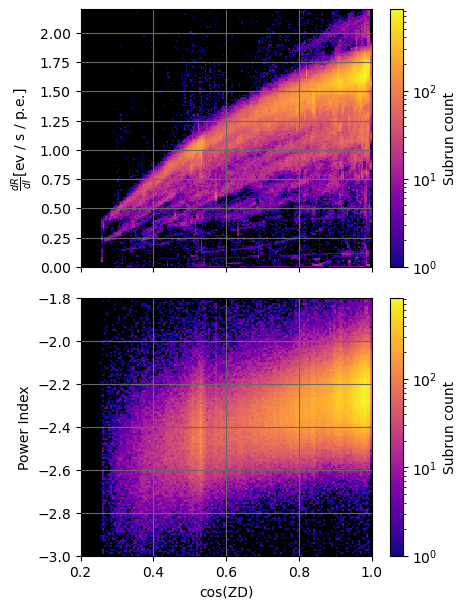

In [7]:
nanmask = np.isnan(merged_dict["cosmics_rate_at_422_pe"])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.5, 6), sharex=True)
hist1 = ax1.hist2d(
    np.cos(np.deg2rad(merged_dict["zd"]))[~nanmask], 
    np.array(merged_dict["cosmics_rate_at_422_pe"])[~nanmask], 
    bins=(np.linspace(0.2, 1, 200), np.linspace(0, 2.2, 200)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)

hist2 = ax2.hist2d(
    np.cos(np.deg2rad(merged_dict["zd"]))[~nanmask], 
    np.array(merged_dict["cosmics_spectral_index"])[~nanmask], 
    bins=(np.linspace(0.2, 1, 150), np.linspace(-3, -1.8, 150)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)
fig.colorbar(hist1[3], label="Subrun count")
fig.colorbar(hist2[3], label="Subrun count")
for ax in [ax1, ax2]:
    ax.set_facecolor("k")
    ax.grid(color="dimgray")
fig.tight_layout()
ax2.set_xlabel("cos(ZD)")
ax1.set_ylabel("$\\frac{dR}{dI}$[ev / s / p.e.]")
ax2.set_ylabel("Power Index")


x_fit = np.linspace(0.2, max(x), 100)
y_fit = quadratic_func(x_fit, p1a, p1b, p1c)
ax2.plot(x_fit, y_fit, 'w', lw=1, ls="--")

x_fit = np.linspace(0.2, max(x), 100)
y_fit = quadratic_func(x_fit, p0a, p0b, p0c)
ax1.plot(x_fit, y_fit, 'w', lw=1, ls="--")


plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
nanmask = np.isnan(merged_dict["cosmics_rate_at_422_pe"])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.5, 6), sharex=True)
hist1 = ax1.hist2d(
    np.array(merged_dict["az"])[~nanmask], 
    np.array(merged_dict["cosmics_rate_at_422_pe"])[~nanmask], 
    bins=(np.linspace(0, 360, 150), np.linspace(0, 2.2, 200)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)

hist2 = ax2.hist2d(
    np.array(merged_dict["az"])[~nanmask], 
    np.array(merged_dict["cosmics_spectral_index"])[~nanmask], 
    bins=(np.linspace(0, 360, 150), np.linspace(-3, -1.8, 150)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)
fig.colorbar(hist1[3], label="Subrun count")
fig.colorbar(hist2[3], label="Subrun count")
for ax in [ax1, ax2]:
    ax.set_facecolor("k")
    ax.grid(color="dimgray")
fig.tight_layout()
ax2.set_xlabel("AZ [deg]")
ax1.set_ylabel("$\\frac{dR}{dI}$[ev / s / p.e.]")
ax2.set_ylabel("Power Index")

plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
nanmask = np.isnan(merged_dict["cosmics_rate_at_422_pe"])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.5, 6), sharex=True)
hist1 = ax1.hist2d(
    np.array(merged_dict["intensity_spectrum_fit_p_value"])[~nanmask], 
    np.array(merged_dict["cosmics_rate_at_422_pe"])[~nanmask], 
    bins=(np.linspace(0, 1, 200), np.linspace(0, 2.2, 200)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)

hist2 = ax2.hist2d(
    np.array(merged_dict["intensity_spectrum_fit_p_value"])[~nanmask], 
    np.array(merged_dict["cosmics_spectral_index"])[~nanmask], 
    bins=(np.linspace(0, 1, 200), np.linspace(-3, -1.8, 150)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)
fig.colorbar(hist1[3], label="Subrun count")
fig.colorbar(hist2[3], label="Subrun count")
for ax in [ax1, ax2]:
    ax.set_facecolor("k")
    ax.grid(color="dimgray")
fig.tight_layout()
ax2.set_xlabel("AZ [deg]")
ax1.set_ylabel("$\\frac{dR}{dI}$[ev / s / p.e.]")
ax2.set_ylabel("Power Index")

plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
nanmask = np.isnan(merged_dict["cosmics_rate_at_422_pe"])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.5, 6), sharex=True)
hist1 = ax1.hist2d(
    np.array(merged_dict["light_yield"])[~nanmask], 
    np.array(merged_dict["cosmics_rate_at_422_pe"])[~nanmask], 
    bins=(np.linspace(0, 1.5, 200), np.linspace(0, 2.2, 200)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)

hist2 = ax2.hist2d(
    np.array(merged_dict["light_yield"])[~nanmask], 
    np.array(merged_dict["cosmics_spectral_index"])[~nanmask], 
    bins=(np.linspace(0, 1.5, 200), np.linspace(-3, -1.8, 150)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)
fig.colorbar(hist1[3], label="Subrun count")
fig.colorbar(hist2[3], label="Subrun count")
for ax in [ax1, ax2]:
    ax.set_facecolor("k")
    ax.grid(color="dimgray")
fig.tight_layout()
ax2.set_xlabel("AZ [deg]")
ax1.set_ylabel("$\\frac{dR}{dI}$[ev / s / p.e.]")
ax2.set_ylabel("Power Index")

plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
nanmask = np.isnan(merged_dict["cosmics_rate_at_422_pe"])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.5, 6), sharex=True)
hist1 = ax1.hist2d(
    np.array(merged_dict["charge_mean"])[~nanmask], 
    np.array(merged_dict["cosmics_rate_at_422_pe"])[~nanmask], 
    bins=(np.linspace(1, 6, 150), np.linspace(0, 2.2, 200)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)

hist2 = ax2.hist2d(
    np.array(merged_dict["charge_mean"])[~nanmask], 
    np.array(merged_dict["cosmics_spectral_index"])[~nanmask], 
    bins=(np.linspace(1, 6, 150), np.linspace(-3, -1.8, 150)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)
fig.colorbar(hist1[3], label="Subrun count")
fig.colorbar(hist2[3], label="Subrun count")
for ax in [ax1, ax2]:
    ax.set_facecolor("k")
    ax.grid(color="dimgray")
fig.tight_layout()
ax2.set_xlabel("AZ [deg]")
ax1.set_ylabel("$\\frac{dR}{dI}$[ev / s / p.e.]")
ax2.set_ylabel("Power Index")

plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
nanmask = np.isnan(merged_dict["cosmics_rate_at_422_pe"])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.5, 6), sharex=True)
hist1 = ax1.hist2d(
    np.array(merged_dict["ra"])[~nanmask], 
    np.array(merged_dict["cosmics_rate_at_422_pe"])[~nanmask], 
    bins=(np.linspace(0, 360, 40), np.linspace(0, 2.2, 200)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)

hist2 = ax2.hist2d(
    np.array(merged_dict["ra"])[~nanmask], 
    np.array(merged_dict["cosmics_spectral_index"])[~nanmask], 
    bins=(np.linspace(0, 360, 40), np.linspace(-3, -1.8, 150)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)
fig.colorbar(hist1[3], label="Subrun count")
fig.colorbar(hist2[3], label="Subrun count")
for ax in [ax1, ax2]:
    ax.set_facecolor("k")
    ax.grid(color="dimgray")
fig.tight_layout()
ax2.set_xlabel("AZ [deg]")
ax1.set_ylabel("$\\frac{dR}{dI}$[ev / s / p.e.]")
ax2.set_ylabel("Power Index")

plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
nanmask = np.isnan(merged_dict["cosmics_rate_at_422_pe"])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.5, 6), sharex=True)
hist1 = ax1.hist2d(
    np.array(merged_dict["dec"])[~nanmask], 
    np.array(merged_dict["cosmics_rate_at_422_pe"])[~nanmask], 
    bins=(np.linspace(0, 90, 40), np.linspace(0, 2.2, 200)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)

hist2 = ax2.hist2d(
    np.array(merged_dict["dec"])[~nanmask], 
    np.array(merged_dict["cosmics_spectral_index"])[~nanmask], 
    bins=(np.linspace(0, 90, 40), np.linspace(-3, -1.8, 150)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)
fig.colorbar(hist1[3], label="Subrun count")
fig.colorbar(hist2[3], label="Subrun count")
for ax in [ax1, ax2]:
    ax.set_facecolor("k")
    ax.grid(color="dimgray")
fig.tight_layout()
ax2.set_xlabel("AZ [deg]")
ax1.set_ylabel("$\\frac{dR}{dI}$[ev / s / p.e.]")
ax2.set_ylabel("Power Index")

plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

Parameters:
* Peak rate
* Half peak intensity
* PWL rate
* PWL index
* RA
* DEC
* az
* dec
* NSB

In [7]:
labels_multiplot = [
    "zd",
    "az",
    "ra",
    "dec",
    "charge_mean",
    "light_yield",
    "cosmics_peak_rate",
    "intensity_at_half_peak_rate",
    "cosmics_spectral_index",
    "cosmics_rate_at_422_pe",
    "intensity_spectrum_fit_p_value"
]

data_multiplot = [
    np.cos(np.deg2rad(merged_dict["zd"])),
    merged_dict["az"],
    merged_dict["ra"],
    merged_dict["dec"],
    merged_dict["charge_mean"],
    merged_dict["light_yield"],
    merged_dict["cosmics_peak_rate"],
    merged_dict["intensity_at_half_peak_rate"],
    merged_dict["cosmics_spectral_index"],
    merged_dict["cosmics_rate_at_422_pe"],
]

labels_multiplot = [
    "cos(ZD)",
    "AZ [deg]",
    "RA",
    "DEC",
    "NSB [?]",
    "LY",
    "Cosmics peak\nrate [ev/s/p.e.]",
    "I @ 1/2 peak\nrate [p.e.]",
    "spectral index",
    "$\\frac{dR}{dI}$ [ev/s/p.e.]",
]
Nbins = 50

bins_multiplot = [
    np.linspace(0.15, 1, Nbins),
    np.linspace(0, 360, Nbins),
    np.linspace(0, 360, int(Nbins/5)),
    np.linspace(0, 90, int(Nbins/5)),
    np.linspace(1, 6, Nbins),
    np.linspace(0, 1.5, Nbins),
    np.linspace(0, 80, Nbins),
    np.linspace(20, 100, Nbins),
    np.linspace(-3, -1, Nbins),
    np.linspace(0, 2.5, Nbins),
]

In [42]:
labels_multiplot = [
    "zd",
    "az",
    "ra",
    "dec",
    "charge_mean",
    "light_yield",
    "cosmics_peak_rate",
    "intensity_at_half_peak_rate",
    "cosmics_spectral_index",
    "cosmics_rate_at_422_pe",
    "intensity_spectrum_fit_p_value"
]

data_multiplot = [
    np.cos(np.deg2rad(merged_dict["zd"])),
    merged_dict["az"],
    merged_dict["charge_mean"],
    merged_dict["light_yield"],
    merged_dict["cosmics_peak_rate"],
    merged_dict["intensity_at_half_peak_rate"],
    merged_dict["cosmics_spectral_index"],
    merged_dict["cosmics_rate_at_422_pe"],
]

labels_multiplot = [
    "cos(ZD)",
    "AZ [deg]",
    "NSB [p.e.]",
    "LY",
    "Cosmics peak\nrate [ev/s/p.e.]",
    "I @ 1/2 peak\nrate [p.e.]",
    "spectral index",
    "$\\frac{dR}{dI}$ [ev/s/p.e.]",
]
Nbins = 150

bins_multiplot = [
    np.linspace(0.2, 1, Nbins),
    np.linspace(0, 360, Nbins),
    np.linspace(1, 6, Nbins),
    np.linspace(0, 1.5, Nbins),
    np.linspace(0, 80, Nbins),
    np.linspace(20, 80, Nbins),
    np.linspace(-3, -1, Nbins),
    np.linspace(0, 2.5, Nbins),
]

In [ ]:
fig, ax = plt.subplots(len(bins_multiplot), len(bins_multiplot), figsize=(15, 15),)




for i in range(len(ax)):
    for j in range(len(ax[i])):


        x, y = np.array(data_multiplot[j]), np.array(data_multiplot[i])
        nanmask = ~(np.isnan(x) | np.isnan(y))
        
        if j > i:
            ax[i][j].set_axis_off()
        elif j == i:
            ax[i][j].set_axis_off()
            if i >= len(ax) / 2:
                ax[i][j].hist(x[nanmask], bins=bins_multiplot[i], histtype="step", orientation="horizontal", color="k")
            else:
                ax[i][j].hist(x[nanmask], bins=bins_multiplot[i], histtype="step", color="k")

        else:
            ax[i][j].hist2d(x[nanmask], 
                            y[nanmask], 
                            bins=(bins_multiplot[j], bins_multiplot[i]), 
                            norm=matplotlib.colors.LogNorm(), 
                            cmap="plasma")
            ax[i][j].set_facecolor("k")
            ax[i][j].grid(color="dimgray")

            ax[i][j].spines['bottom'].set_color("w")
            ax[i][j].spines['top'].set_color("w") 
            ax[i][j].spines['right'].set_color("w")
            ax[i][j].spines['left'].set_color("w")

        if j - i == -1 :
            ax[i][j].spines['top'].set_color("k") 
            ax[i][j].spines['right'].set_color("k")    
        if i != (len(ax)- 1):
            ax[i][j].set_xticklabels([])
        else:
            ax[i][j].spines['bottom'].set_color("k")
            ax[i][j].set_xlabel(labels_multiplot[j])
            # newxticks = ["", *[t.get_text() for t in ax[i][j].get_xticklabels()[1:-1]], ""]
            # ax[i][j].set_xticklabels(newxticks)
            
        if j != 0:
            ax[i][j].set_yticklabels([])
        else:
            ax[i][j].spines['left'].set_color("k")
            ax[i][j].set_ylabel(labels_multiplot[i])
            # newyticks = ["", *[t.get_text() for t in ax[i][j].get_yticklabels()[1:-1]], ""]
            # ax[i][j].set_yticklabels(newyticks)
            
            
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

In [36]:
a = newyticks[1]
a.get_text()

'10000'

['', [Text(10000.0, 0, '10000'), Text(20000.0, 0, '20000')], '']